In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nlg

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import limexperiments as lime
import regiontools as rt
import timeseriestools as ts


import cobetools as ct
import ertools as er
import haditools as ht


# Applying a Linear Inverse Model (LIM) to observed Sea Surface Temperatures (SSTs)
This notebook demonstrates an example of how to apply the LIM, which assumes a data set to be written as a Markov Chain. This practice will be applied to observed SSTs between the years 1919 and 2018 across three different products; The ERSSTv5, HadISST, and COBESSTv2. In this notebook, the LIM is built from SST's that have the global mean SST regressed out at every grid point of the SST field, which is reflective of the fact that SSTs under climate change have increased at a nonlinear rate over that last 100 years. In this notebook, the LIM is applied in two ways. First, the predictive capacity of the LIM is tested for the three data sets. Next, the properties of the LIM are examined through the eigenvalues of the operator matrix. More detailed descriptions of the processes are given below. The general strructure of this notebook is as follows:
- The AMV index of the three data sets
- The original AMV pattern (The correlation between every grid point of the SST field and the AMV Index).
- Prediction attempts with the LIM
- The least damped mode that is dominant in the LIM.
- For further analysis, the second least damped mode of the LIM

### First reading out the three data sets

In [2]:
sst_er = er.all_sstInRegion(1919,2018,lonBounds=[280,360], latBounds=[0,66])
globe_er = er.erTimeSeries(1919,2018,lonBounds=[0,360],latBounds=[-90,90])
lon_er,lat_er = er.readLonLat()
lonr,latr = er.regionLonLat(lonBounds=[280,360], latBounds=[0,66])

lon_er = lon_er[lonr]
lat_er = lat_er[latr]

del(lonr,latr)

sst_er = rt.annualScaleRegion(sst_er)
globe_er = ts.annualScale(globe_er)

In [3]:
sst_ct = ct.regionSST(1919,2018,lonBounds=[280,360], latBounds=[0,66])
globe_ct = ct.sstTimeSeries(1919,2018,lonBounds=[0,360],latBounds=[-90,90])
lon_ct,lat_ct = ct.regionLonLat(lonBounds=[280,360], latBounds=[0,66])

sst_ct,lat_ct,lon_ct = rt.adjustAllRes(sst_ct,lat_ct,lon_ct,33,41)

sst_ct = rt.annualScaleRegion(sst_ct)
globe_ct = ts.annualScale(globe_ct)

In [4]:
sst_ht = ht.regionSST(1919,2018,lonBounds=[-80,0], latBounds=[0,66])
globe_ht = ht.sstTimeSeries(1919,2018,lonBounds=[-180,180],latBounds=[-90,90])
lon_ht,lat_ht = ht.regionLonLat(lonBounds=[-80,0], latBounds=[0,66])

sst_ht,lat_ht,lon_ht = rt.adjustAllRes(sst_ht,lat_ht,lon_ht,33,41)

sst_ht = rt.annualScaleRegion(sst_ht)
globe_ht = ts.annualScale(globe_ht)

### Getting basic LIM diagnostic information to ensure the LIM works well for each of the data sets in question

In [5]:
neof_er = 6
neof_ct = 4
neof_ht = 5

limR_er = lime.limDiagnostics(sst_er,neof_er,lon_er,lat_er,globe_er,False,-1)
limR_ct = lime.limDiagnostics(sst_ct,neof_ct,lon_ct,lat_ct,globe_ct,False,-1)
limR_ht = lime.limDiagnostics(sst_ht,neof_ht,lon_ht,lat_ht,globe_ht,False,-1)

/Volumes/ARTEMIS/Docs/Work/Analysis/limexperiments.py:285: RuntimeWarning: Mean of empty slice
  S = S - np.nanmean(S,axis=0)
/Volumes/ARTEMIS/Docs/Work/Analysis/limtools.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  M[t,vals] = np.copy(x[t,:])


### Gathering and plotting the AMV Index and correlation pattern

In [6]:
sst_er = limR_er['sst']
sst_ct = limR_ct['sst']
sst_ht = limR_ht['sst']

amv_er = limR_er['amv']
amv_ct = limR_ct['amv']
amv_ht = limR_ht['amv']

In [7]:
corr_er = rt.corrGrid(amv_er,sst_er)
corr_ct = rt.corrGrid(amv_ct,sst_ct)
corr_ht = rt.corrGrid(amv_ht,sst_ht)

corr_list = [corr_er,corr_ct,corr_ht]
lon_list = [lon_er, lon_ct, lon_ht]
lat_list = [lat_er,lat_ct,lat_ht]

years = np.arange(1919,2019)

amv_list = [amv_er,amv_ct,amv_ht]
lab_list = ['ERSSTv5','COBESSTv2','HadISST']

## Plots of thhe AMV indices for the three data sets

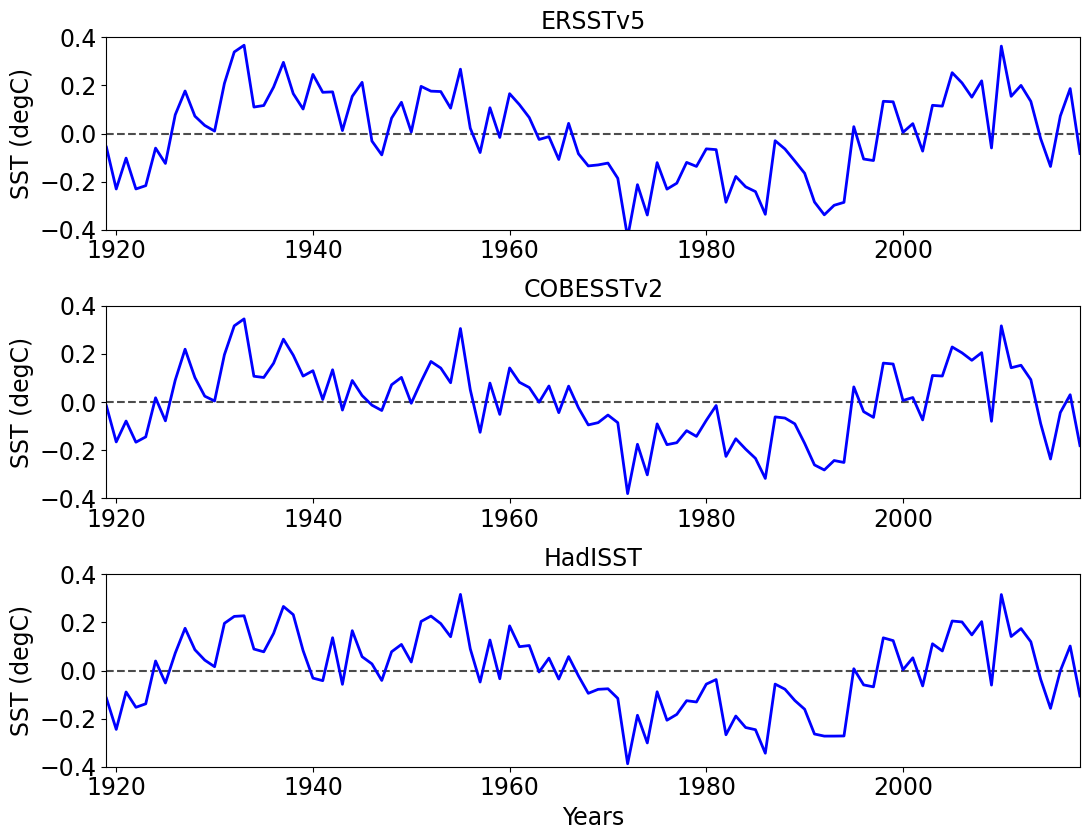

In [8]:
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(11,8.5))
fs = 17
axs = axs.flatten()

for i,ax in enumerate(axs):
    label = lab_list[i]
    amv = amv_list[i]

    ax.plot(years,amv,'b',linewidth=2)
    if(i==2):
        ax.set_xlabel('Years',fontsize=fs)
    ax.set_ylabel('SST (degC)',fontsize=fs)

    ax.set_title(label,fontsize=fs)
    ax.tick_params(labelsize=fs)

    ax.hlines(0,min(years),max(years),linestyles='dashed',colors='k',alpha=0.7)
    
    ax.axis([min(years),max(years),-0.4,0.4])
fig.tight_layout()
plt.show()

### Plotting the correlation patterns of the AMV

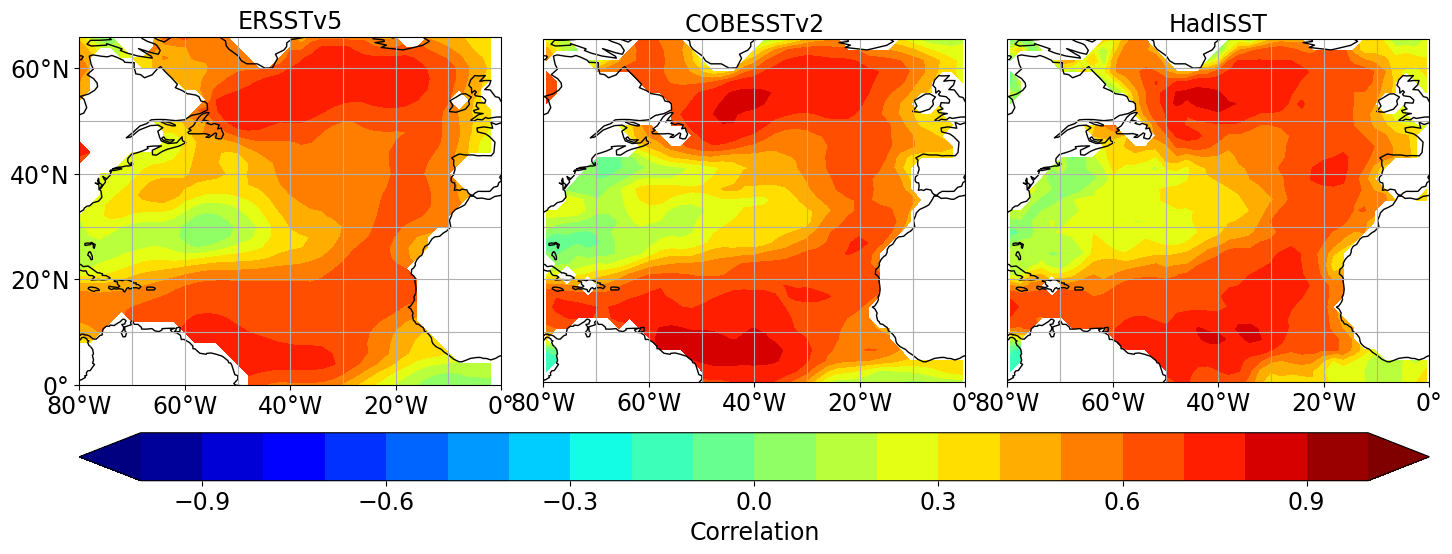

In [9]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,6),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.flatten()
for i,ax in enumerate(axs):
    #lab = label_list[i]
    lon = lon_list[i]
    lat = lat_list[i]
    corr = corr_list[i]
    lab = lab_list[i]
    cs = ax.contourf(lon,lat,corr,cmap='jet',levels=np.arange(-1.,1.1,.1), extend='both', transform=ccrs.PlateCarree())
    
    #Longitude Labels
    ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if(i==0):
        #Latitude Labels
        ax.set_yticks(np.arange(0,67,20),crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    
    ax.coastlines()
    ax.gridlines()
    ax.set_title(lab,fontsize=fs)
    
    ax.tick_params(labelsize=fs)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.2,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.3)

cbar_ax = fig.add_axes([0.05,0.1,0.9,0.08])
cbar_ax.tick_params(labelsize=fs)
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal')#,label='RMS/RMS_clim')
cbar.set_label('Correlation', fontsize=fs)

plt.show()

## Using the LIM to generate predictions
To test the predictive capabilities of the LIM, one decade of SSTs is removed from the total field and the remaining 90 years are used to build the LIM. Once the LIM is constructed, it is used to predict the decade that is removed. This process is repeated unti every possible decade is removed and a LIM is constructed to predict the removed decade. The prediction skill, plotted onto the entire North Atlantic SST grid, is demonstrated with the Root Mean Square Error relative to climatology (ie RMS/RMS_clim). This is convenient because we can define a good prediction as one that is better than climatology (less that 1) and a bad prediction as one that is worse than guessing climatology (greater than 1). 

In [10]:
rms_er = lime.rmsRegionTest(sst_er,neof_er,lon_er,lat_er,globe_er,False,-1)
rms_ct = lime.rmsRegionTest(sst_ct,neof_ct,lon_ct,lat_ct,globe_ct,False,-1)
rms_ht = lime.rmsRegionTest(sst_ht,neof_ht,lon_ht,lat_ht,globe_ht,False,-1)

/Volumes/ARTEMIS/Docs/Work/Analysis/limtools.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[n,:] = np.dot(Gr(t),y0)


In [11]:
lags = ['1-2 Years', '3-5 Years', '6-8 Years']

lon_list = [lon_er,lon_ct,lon_ht]
lat_list = [lat_er,lat_ct,lat_ht]

rms_list = [rms_er,rms_ct,rms_ht]


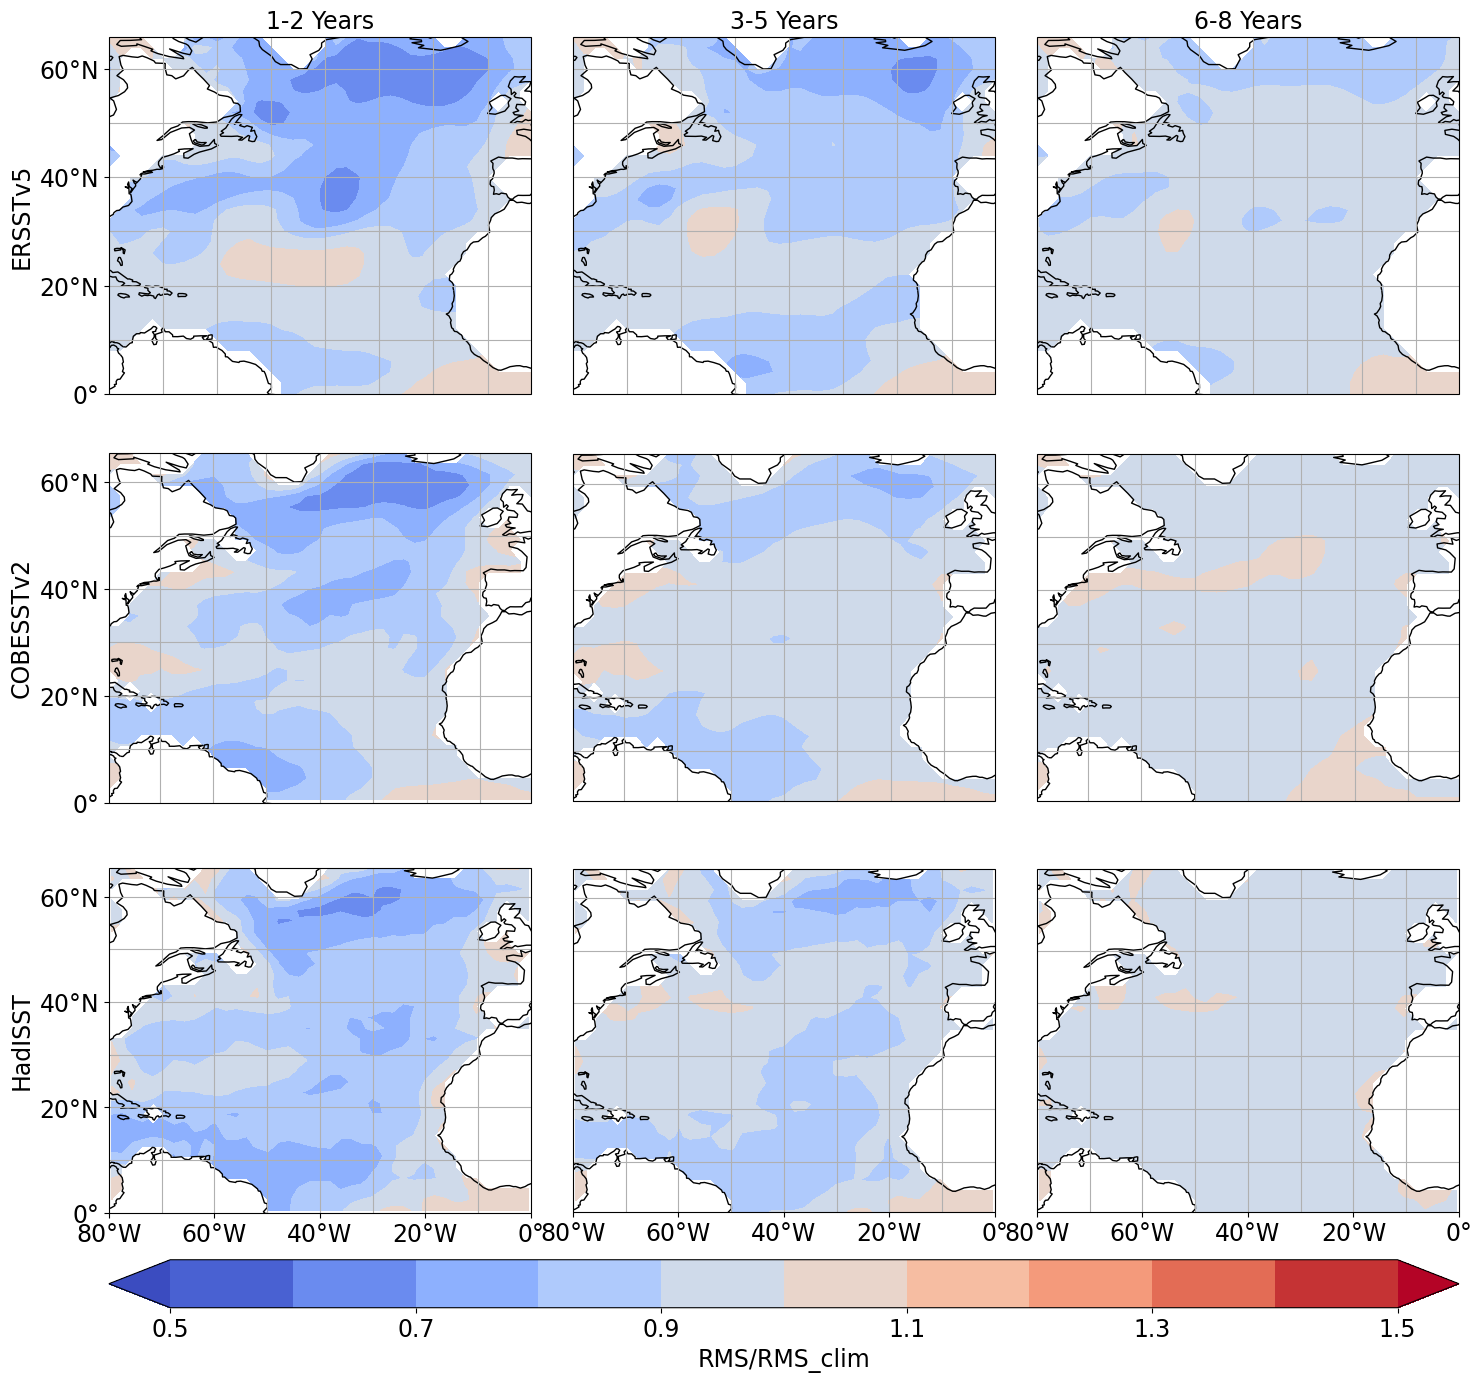

In [12]:
fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(15,16),subplot_kw={'projection':ccrs.PlateCarree()})
ax = ax.flatten()
fs=17
k = 0
for i, a in enumerate(ax):
    l = i%3
    if(l==0 and i>2):
        k += 1

    lon = lon_list[k]
    lat = lat_list[k]
    r = rms_list[k][l]

    cs = a.contourf(lon,lat,r,cmap='coolwarm',levels=np.arange(.5,1.6,.1),extend='both',transform=ccrs.PlateCarree())
    #a.set_extent([-80,0,0,66])
    
    if(k==2):
        #Longitude Labels
        a.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        a.xaxis.set_major_formatter(lon_formatter)
        #a.tick_params(labelsize=fs)
    if(l==0):
        #Latitude Labels
        a.set_yticks(np.arange(0,67,20),crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        a.yaxis.set_major_formatter(lat_formatter)

    a.tick_params(labelsize=fs)
    a.coastlines()
    a.gridlines()
    if(i<3):
        a.set_title(lags[i],fontsize=fs)
    if(l==0):    
        a.set_ylabel(lab_list[k],fontsize=fs)
    
fig.subplots_adjust(bottom=0.15,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.1)

cbar_ax = fig.add_axes([0.05,0.1,0.9,0.03])
cbar_ax.tick_params(labelsize=fs)
cbar_ax.tick_params()#labelsize=fs)
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal')#,label='RMS/RMS_clim')
cbar.set_label('RMS/RMS_clim', fontsize=fs)
plt.show()

## Examination of the Modes of the LIM.
Because we take the LIM to be a Markov process of the form dX/dt = Lx(t) + noise(t), the eigenvalues of the operator matrix L calculated from the full 100 years of SSTs can illustrate the behavior of the system. complex eigenvalues of L in the form a+bi illustrate both a decay rate of the form -1/a and an oscillatory period of the form 2*pi/b. Generally, the longest decay rate, referred to as thhe least damped mode, implies dominant behavior of the LIM. In order to assess the role the least damped mode plays in the role of the LIM, its associated eigenvector can be proected onto the data set. This section will plot out the two least damped modes for each data set to give a nice glimpse nito the behaviors of the three LIMs. After the least damped mode has been proected onto the LIM, a correlation map with the SST field is generated in order to see the spatial patterns inherent into the LIM.

### Making a table the decay rates and the oscillatory periods of the modes

In [24]:
decay_er = -1/limR_er['modes'].real
decay_ct = -1/limR_ct['modes'].real
decay_ht = -1/limR_ht['modes'].real

osc_er = np.abs(2*np.pi/limR_er['modes'].imag)
osc_ct = np.abs(2*np.pi/limR_ct['modes'].imag)
osc_ht = np.abs(2*np.pi/limR_ht['modes'].imag)

decay_list = [decay_er,decay_ct,decay_ht]
osc_list = [osc_er,osc_ct,osc_ht]


for i,decays in enumerate(decay_list):
    print(lab_list[i])

    for k,dec in enumerate(decays):
        print('\tMode ', k+1)
        print('\t\tDecay: ', dec,' years')
        print('\t\tOscillatory Period: ', osc_list[i][k], ' years')



ERSSTv5
	Mode  1
		Decay:  0.2618467842931568  years
		Oscillatory Period:  inf  years
	Mode  2
		Decay:  0.6089337073002152  years
		Oscillatory Period:  inf  years
	Mode  3
		Decay:  7.6470705278357  years
		Oscillatory Period:  inf  years
	Mode  4
		Decay:  1.2859748628590537  years
		Oscillatory Period:  13.202881858430404  years
	Mode  5
		Decay:  1.2859748628590537  years
		Oscillatory Period:  13.202881858430404  years
	Mode  6
		Decay:  1.9083395864372616  years
		Oscillatory Period:  inf  years
COBESSTv2
	Mode  1
		Decay:  0.22238232195200552  years
		Oscillatory Period:  inf  years
	Mode  2
		Decay:  0.716822997550256  years
		Oscillatory Period:  inf  years
	Mode  3
		Decay:  4.544983430059061  years
		Oscillatory Period:  inf  years
	Mode  4
		Decay:  1.3871836233470367  years
		Oscillatory Period:  inf  years
HadISST
	Mode  1
		Decay:  0.17438055808509134  years
		Oscillatory Period:  inf  years
	Mode  2
		Decay:  0.8982242031865388  years
		Oscillatory Period:  inf  years

<ipython-input-24-e28ff244e3c4>:5: RuntimeWarning: divide by zero encountered in true_divide
  osc_er = np.abs(2*np.pi/limR_er['modes'].imag)
<ipython-input-24-e28ff244e3c4>:6: RuntimeWarning: divide by zero encountered in true_divide
  osc_ct = np.abs(2*np.pi/limR_ct['modes'].imag)
<ipython-input-24-e28ff244e3c4>:7: RuntimeWarning: divide by zero encountered in true_divide
  osc_ht = np.abs(2*np.pi/limR_ht['modes'].imag)


In [14]:
p_er = limR_er['modeProj']['3']['series'].real
p_ct = limR_ct['modeProj']['4']['series'].real
p_ht = limR_ht['modeProj']['4']['series'].real

corr_er = rt.corrGrid(p_er,sst_er)
corr_cobe = rt.corrGrid(p_ct,sst_ct)
corr_hadi = rt.corrGrid(p_ht,sst_ht)

corr_list = [corr_er,corr_cobe,corr_hadi]
lon_list = [lon_er, lon_ct, lon_ht]
lat_list = [lat_er,lat_ct,lat_ht]

In [15]:
corr_er = rt.corrGrid(p_er,sst_er)
corr_cobe = rt.corrGrid(p_ct,sst_ct)
corr_hadi = rt.corrGrid(p_ht,sst_ht)

corr_list = [corr_er,corr_cobe,corr_hadi]
lon_list = [lon_er, lon_ct, lon_ht]
lat_list = [lat_er,lat_ct,lat_ht]

lab_list = ['ERSSTv5','COBESSTv2','HadISST']

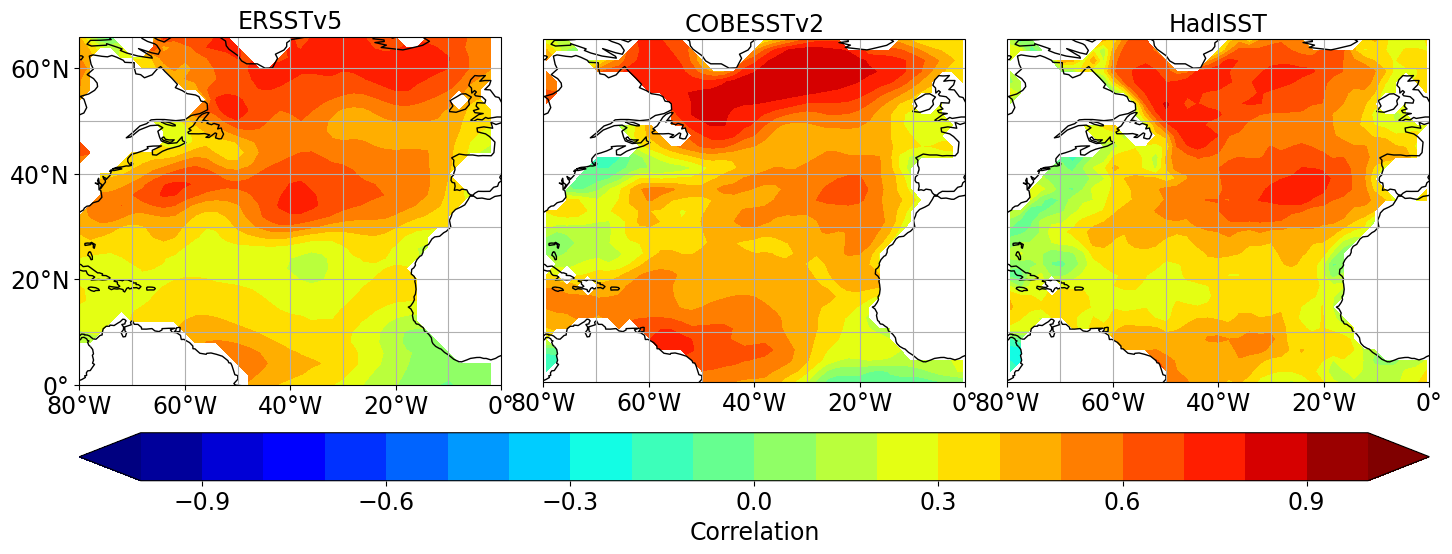

In [16]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,6),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.flatten()
for i,ax in enumerate(axs):
    #lab = label_list[i]
    lon = lon_list[i]
    lat = lat_list[i]
    corr = corr_list[i]
    lab = lab_list[i]
    cs = ax.contourf(lon,lat,corr,cmap='jet',levels=np.arange(-1.,1.1,.1), extend='both', transform=ccrs.PlateCarree())
    
    #Longitude Labels
    ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if(i==0):
        #Latitude Labels
        ax.set_yticks(np.arange(0,67,20),crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    
    ax.coastlines()
    ax.gridlines()
    ax.set_title(lab,fontsize=fs)
    
    ax.tick_params(labelsize=fs)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.2,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.3)

cbar_ax = fig.add_axes([0.05,0.1,0.9,0.08])
cbar_ax.tick_params(labelsize=fs)
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal')#,label='RMS/RMS_clim')
cbar.set_label('Correlation', fontsize=fs)

plt.show()

In [19]:
p_er = limR_er['modeProj']['6']['series'].real
p_ct = limR_ct['modeProj']['4']['series'].real
p_ht = limR_ht['modeProj']['5']['series'].real

corr_er = rt.corrGrid(p_er,sst_er)
corr_cobe = rt.corrGrid(p_ct,sst_ct)
corr_hadi = rt.corrGrid(p_ht,sst_ht)

corr_list = [corr_er,corr_cobe,corr_hadi]
lon_list = [lon_er, lon_ct, lon_ht]
lat_list = [lat_er,lat_ct,lat_ht]

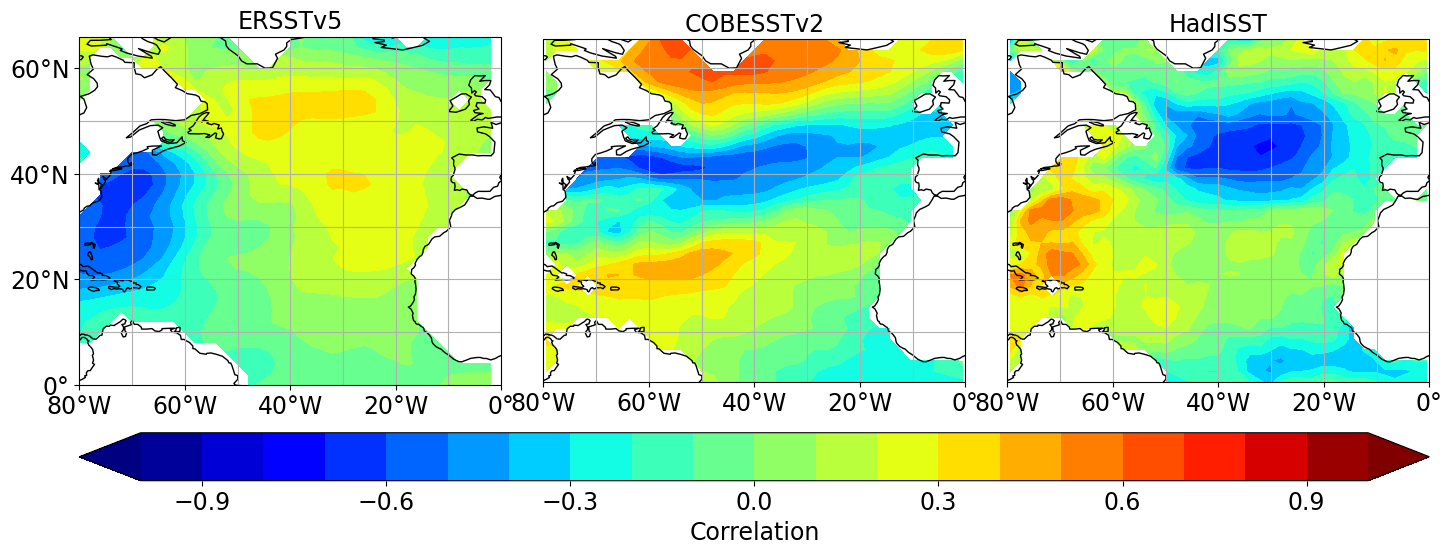

In [20]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,6),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.flatten()
for i,ax in enumerate(axs):
    #lab = label_list[i]
    lon = lon_list[i]
    lat = lat_list[i]
    corr = corr_list[i]
    lab = lab_list[i]
    cs = ax.contourf(lon,lat,corr,cmap='jet',levels=np.arange(-1.,1.1,.1), extend='both', transform=ccrs.PlateCarree())
    
    #Longitude Labels
    ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if(i==0):
        #Latitude Labels
        ax.set_yticks(np.arange(0,67,20),crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    
    ax.coastlines()
    ax.gridlines()
    ax.set_title(lab,fontsize=fs)
    
    ax.tick_params(labelsize=fs)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.2,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.3)

cbar_ax = fig.add_axes([0.05,0.1,0.9,0.08])
cbar_ax.tick_params(labelsize=fs)
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal')#,label='RMS/RMS_clim')
cbar.set_label('Correlation', fontsize=fs)

plt.show()